In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold

In [2]:
data = pd.read_csv(r"C:\Zhongming Lu\hk_bld\eui\final data\hk_eui_sample_for_analysis.csv",index_col=0,encoding='ISO-8859-1')
data = data.drop(['dist_searc','AddressofB','Expiry_dat','BEC_name','BEC_addres','Date_FOC','Date_EA','Date_FoC_1',
                 'x','y','result_cod','English_bu','Street_No','E_Estate_N',
                 'District','bld_x','bld_y','bld_code','TPU','Shape_Leng'],axis=1)
data = data[(data.TPU_join>0) & (data.bld_info_j>0) & (data.manual_che == 0)]
data = data[ (data.highrise_j>0) | (data.podium_j>0) ]
data = data[(data.kWh_m2_ann>10) & (data.kWh_m2_ann<400)]
data = data[(data.Year_Built>0) & (data.No_of_Stor>0)]

In [3]:
data['Area'] = np.where(data['highrise'] == 1, data['highrise_a'], data['podium_are'])

In [4]:
data['retro_before'] = np.where(data['retro']=='Before',1,0)
data['retro_after'] = np.where(data['retro']=='After',1,0)

In [5]:
data['log_area'] = np.log10(data['Area']+1)
data['log_hotel_kern'] = np.log10(data['hotel_kern']+1)
data['log_retail_ker'] = np.log10(data['retail_ker']+1)
data['log_parking_ke'] = np.log10(data['parking_ke']+1)
data['log_food_kerne'] = np.log10(data['food_kerne']+1)
data['log_office_ker'] = np.log10(data['office_ker']+1)

In [6]:
data['log_mtr_dist'] = np.log10(data['mtr_dist'])

In [7]:
data['commercial'] = np.where(data['RASTERVALU']==11,1,0)

In [8]:
y = data['kWh_m2_ann'].reset_index(drop=True)

In [9]:
log_y = np.log10(y)

In [10]:
log_eui_median = log_y.median()
log_eui_median

1.778729923996112

In [11]:
log_y_category = pd.cut(log_y, bins=5)
log_y_weight = compute_sample_weight('balanced',log_y_category)

In [156]:
#Weight adjustment
#for i in range(len(log_y)):
#    if log_y[i]<=1.2 or log_y[i]>2.25:
#        log_y_weight[i] = log_y_weight[i]*32
#    elif log_y[i]>1.70 and log_y[i]<1.90:
#        log_y_weight[i] = log_y_weight[i]/16
#    else:
#        log_y_weight[i] = log_y_weight[i]*6

In [12]:
X = data[['log_hotel_kern','log_parking_ke','log_food_kerne','log_office_ker','log_retail_ker','DNI_HK','HKG_wind_s','tsd_mask','log_area',
         'No_of_Stor','Year_Built','retro_before','retro_after','log_mtr_dist','is_commercial']].reset_index(drop=True)

In [13]:
seed = 8000

In [14]:
log_y_values = log_y.values.reshape(-1,1)
X_values = X.values

In [15]:
sc_log_y_values = StandardScaler()
sc_X_values = StandardScaler()
log_y_values = sc_log_y_values.fit_transform(log_y_values).flatten()
X_values = sc_X_values.fit_transform(X_values)

In [161]:
log_y_values

array([-0.64210489, -1.49586768,  0.72763108, ...,  0.28893126,
       -0.13158714,  0.59866653])

In [162]:
np.random.seed(8000)
c_range = np.random.uniform(0.0,20.0,100)
gamma_range = ['scale','auto']
epsilon_range = np.random.uniform(0.0,0.2,20)

In [163]:
hyperparameters = {'gamma': list(gamma_range), 
                    'C': list(c_range),
                   'epsilon': list(epsilon_range)}

In [164]:
svr_CV = RandomizedSearchCV(SVR(kernel='rbf', ), param_distributions=hyperparameters, n_iter=200, 
                            cv = 5, verbose=2, random_state= seed, n_jobs = -1, scoring='r2')

In [165]:
svr_CV.fit(X_values, log_y_values, sample_weight=log_y_weight)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   30.3s finished


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=200, n_jobs=-1,
                   param_distributions={'C': [17.153397763096166,
                                              18.85253664735223,
                                              8.33431800509332,
                                              2.173075359418173,
                                              6.406130654988951,
                                              19.123614533596452,
                                              17.988738245792582,
                                              6.756708877629299,
                                              7.853721285470088,
                                              16.75034090452481,
                                              4.951106041020998,
                                              19.401277613689757,
                                              17.446021708481886,
                                              3.4579792082956984,
                    

In [166]:
svr_CV.best_params_

{'gamma': 'auto', 'epsilon': 0.07906818695202925, 'C': 0.34241977486852093}

In [167]:
svr_best = SVR(kernel='rbf', C=svr_CV.best_params_['C'], gamma=svr_CV.best_params_['gamma'], epsilon=svr_CV.best_params_['epsilon'])

In [16]:
best_params_ = {'gamma': 'auto', 'epsilon': 0.07906818695202925, 'C': 0.34241977486852093}

In [17]:
svr_best = SVR(kernel='rbf', C=best_params_['C'], gamma=best_params_['gamma'], epsilon=best_params_['epsilon'])

In [168]:
#X_train, X_test, y_train, y_test, weight_train, weight_test = train_test_split(X_values, log_y_values, log_y_weight, test_size=0.2, random_state=8000)

In [169]:
#svr_rbf.fit(X_train, y_train, weight_train)

In [18]:
cv = KFold(n_splits=5, random_state=seed, shuffle=True)

for (train, test), i in zip(cv.split(X_values, log_y_values), range(5)):
    svr_best.fit(X_values[train], log_y_values[train], sample_weight = log_y_weight[train])
    y_pred = svr_best.predict(X_values[test])
    y_pred = sc_log_y_values.inverse_transform(y_pred) 
    y_test = sc_log_y_values.inverse_transform(log_y_values[test])
    #log_y_pred = qt.inverse_transform(log_y_transform_pred.reshape(-1,1))
    
    
    accuracy_num = 0 
    
    for i in range(len(y_pred)):
        if y_test[i] > log_eui_median:
            if y_pred[i] > log_eui_median:
                accuracy_num = accuracy_num + 1
        if y_test[i] <= log_eui_median:
            if y_pred[i] <= log_eui_median:
                accuracy_num = accuracy_num + 1
                
    rmse_test = metrics.mean_squared_error(y_test, y_pred, squared=False)
    r2_test = metrics.r2_score(y_test,y_pred)
    accuarcy_test = "{:.2%}".format(accuracy_num/len(y_pred))
    print ('RMSE: %.4f'%rmse_test)
    print ('R2: %.4f'%r2_test)
    print ('Accuracy: ', accuarcy_test)

RMSE: 0.3307
R2: 0.2152
Accuracy:  71.43%
RMSE: 0.3137
R2: 0.2727
Accuracy:  69.52%
RMSE: 0.3048
R2: 0.3280
Accuracy:  78.10%
RMSE: 0.3109
R2: 0.2887
Accuracy:  70.95%
RMSE: 0.3100
R2: 0.2260
Accuracy:  74.64%


In [19]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["savefig.dpi"] = 300

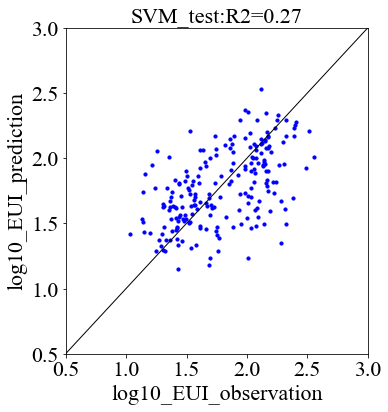

In [21]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(y_test, y_pred, color='b', s=10)    
ax.plot([-10,10],[-10,10], color='k', linewidth=1)
ax.set_xlim([0.5,3])
ax.set_ylim([0.5,3])
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title("SVM_test:R2=0.27", fontsize=22)
#ax.annotate('R2=0.31',(1.5,2.5), fontsize=22)
#ax.set_title("%f Error Plot"%(r2_score(y_test, y_pred)), fontsize=17)
#ax.set_title("%f Error Plot"%(mean_squared_error(log_y_transform_s,log_y_transform_pred,squared=False)), fontsize=17)
ax.set_xlabel("log10_EUI_observation", fontsize=22)
ax.set_ylabel("log10_EUI_prediction", fontsize=22)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.subplots_adjust(left=0.2,right=0.9)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\svm_test.png')

plt.show()
plt.close()

In [141]:
y_pred = svr_best.predict(X_values)
y_pred = sc_log_y_values.inverse_transform(y_pred) 
y_true = sc_log_y_values.inverse_transform(log_y_values)

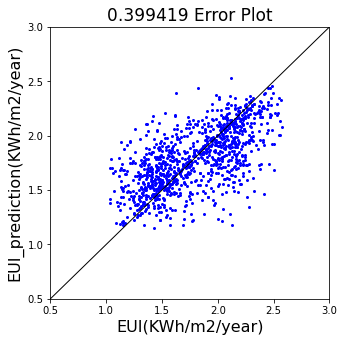

In [142]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(y_true, y_pred, color='b', s=4, label="Predicted")    
ax.plot([-10,10],[-10,10], color='k', linewidth=1)
ax.set_xlim([0.5,3])
ax.set_ylim([0.5,3])
ax.set_title("%f Error Plot"%(metrics.r2_score(y_true, y_pred)), fontsize=17)
#ax.set_title("%f Error Plot"%(metrics.mean_squared_error(log_y_reset,log_y_pred,squared=False)), fontsize=17)
ax.set_xlabel("EUI(KWh/m2/year)", fontsize=16)
ax.set_ylabel("EUI_prediction(KWh/m2/year)", fontsize=16)
plt.show()
plt.close()

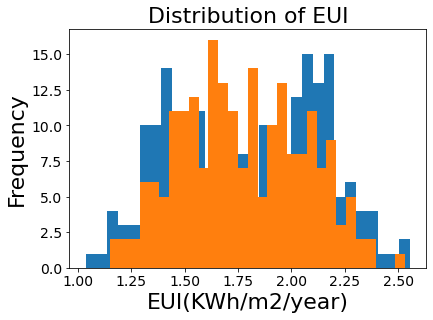

In [172]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))
plt.hist(y_test,bins=30)
plt.hist(y_pred,bins=30)

ax.set_title("Distribution of EUI", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("EUI(KWh/m2/year)", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()